# Model Explanation with Santander Dataset

Model explanability is an important topic since machine learning algorithms have long been termed as black boxes. However, most of time it's not a black box and we can take advantage of some plots to figure out what the underlying algorithm is doing.

In this notebook, we will discuss the following four techniques.

1. **Tree visualization**

2. **Permutation Feature Importance**

3. **Partial Dependence Plot**

4. **SHAP values**

### Load Package

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import numba as nb
warnings.filterwarnings('ignore')
%matplotlib inline

### Display set up

In [2]:
# display set up
from sklearn.model_selection import StratifiedKFold
fold_n=5
folds = StratifiedKFold(n_splits=fold_n, shuffle=True, random_state=10)
%precision 4
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
np.set_printoptions(suppress=True)
pd.set_option("display.precision", 15)

### Load Data

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.925500000000000,-6.7863,11.908099999999999,5.093000000000000,11.460699999999999,-9.2834,5.1187,18.626600000000000,...,4.4354,3.9642,3.1364,1.691000000000000,18.522700000000000,-2.3978,7.8784,8.563499999999999,12.780300000000000,-1.091400000000000
1,train_1,0,11.500600000000000,-4.1473,13.858800000000000,5.388999999999999,12.362200000000000,7.0433,5.6208,16.533799999999999,...,7.6421,7.7214,2.5837,10.951599999999999,15.430500000000000,2.0339,8.1267,8.788900000000000,18.355999999999998,1.951800000000000
2,train_2,0,8.609299999999999,-2.7457,12.080500000000001,7.892800000000000,10.582500000000000,-9.0837,6.9427,14.615500000000001,...,2.9057,9.7905,1.6704,1.685800000000000,21.604199999999999,3.1417,-6.5213,8.267500000000000,14.722200000000001,0.396500000000000
3,train_3,0,11.060400000000000,-2.1518,8.952199999999999,7.195700000000000,12.584600000000000,-1.8361,5.8428,14.925000000000001,...,4.4666,4.7433,0.7178,1.421400000000000,23.034700000000001,-1.2706,-2.9275,10.292199999999999,17.969700000000000,-8.999599999999999
4,train_4,0,9.836900000000000,-1.4834,12.874599999999999,6.637500000000000,12.277200000000001,2.4486,5.9405,19.251400000000000,...,-1.4905,9.5214,-0.1508,9.194200000000000,13.287599999999999,-1.5121,3.9267,9.503100000000000,17.997399999999999,-8.810400000000000


In [5]:
test.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.953600000000000,9.4292,11.432700000000001,-2.380500000000000,5.8493,18.267499999999998,2.1337,...,-2.1556,11.849500000000001,-1.4300,2.4508,13.711200000000000,2.4669,4.3654,10.720000000000001,15.472200000000001,-8.719700000000000
1,test_1,8.5304,1.2543,11.304700000000000,5.1858,9.197400000000000,-4.011700000000000,6.0196,18.631599999999999,-4.4131,...,10.6165,8.834899999999999,0.9403,10.1282,15.576499999999999,0.4773,-1.4852,9.871400000000000,19.129300000000001,-20.975999999999999
2,test_2,5.4827,-10.3581,10.140700000000001,7.0479,10.262800000000000,9.805199999999999,4.8950,20.253699999999998,1.5233,...,-0.7484,10.993499999999999,1.9803,2.1800,12.981299999999999,2.1281,-7.1086,7.061800000000000,19.895600000000002,-23.179400000000001
3,test_3,8.5374,-1.3222,12.022000000000000,6.5749,8.845800000000001,3.174400000000000,4.9397,20.565999999999999,3.3755,...,9.5702,9.076599999999999,1.6580,3.5813,15.187400000000000,3.1656,3.9567,9.229500000000000,13.016800000000000,-4.210800000000000
4,test_4,11.7058,-0.1327,14.129500000000000,7.7506,9.103500000000000,-8.584800000000000,6.8595,10.604799999999999,2.9890,...,4.2259,9.172300000000000,1.2835,3.3778,19.554200000000002,-0.2860,-5.1612,7.288200000000000,13.925999999999998,-9.184600000000000


### Check missing value

In [6]:
def check_missing_value(data):
    totalna = data.isnull().sum().sum()
    print(f"Total missing value: {totalna}")

In [7]:
check_missing_value(train)

Total missing value: 0


In [8]:
check_missing_value(test)

Total missing value: 0


Let's take a look at the target variable.

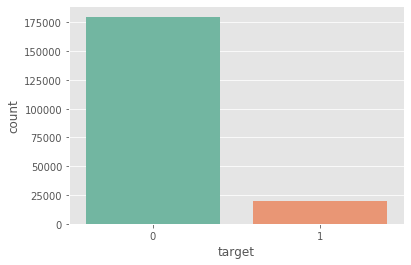

In [12]:
sns.countplot(train['target'],palette='Set2')

In [13]:
per = 100*train['target'].sum() / train.shape[0]
print(f"There are {per}% of the target values that are 1.")

if 40 <= per <= 60:
    print("This data set is balanced within the target value.")
else:
    print("This data set is unbalanced within the target value.")

There are 10.049% of the target values that are 1.
This data set is unbalanced within the target value.


---
## Machine Learning Explainability

In [14]:
cols = ["target","ID_code"]
X = train.drop(cols,axis=1)
y = train["target"]

X_test  = test.drop("ID_code",axis=1)

For visualization purposes, let's randomly select 20 features for visualization.

In [38]:
X.shape

(200000, 200)

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=100)

col = np.random.choice(X_train.columns, size=50, replace=False)
X_train = X_train[col]
X_test = X_test[col]

### Part 1. Tree Visualization

Tree visualization is a very basic technique to visualize tree based algorithms. Tree-based algorithms are popular as the choice of the final output model since it is easy to understand by both domain experts and practitioners. 

In [145]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
import graphviz

In [146]:
tree_model = DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_split=5)
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [147]:
features = [c for c in X_train.columns if c not in ['ID_code', 'target']]
tree_graph = tree.export_graphviz(tree_model, out_file=None, feature_names=features)

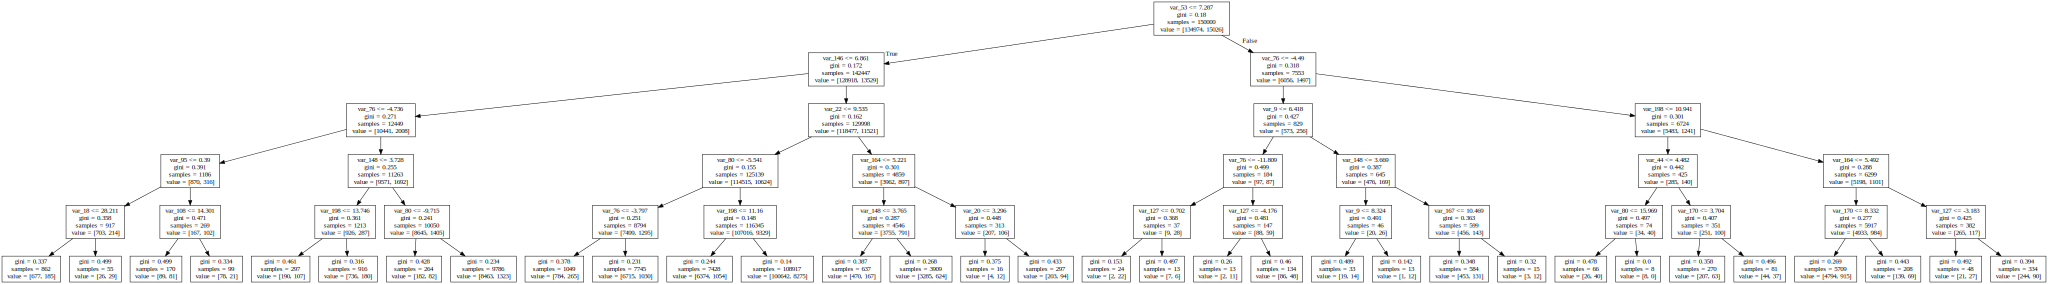

In [148]:
graphviz.Source(tree_graph)

As guidance to read the tree:

1. Leaves with children show their splitting criterion on the top.

2. The pair of values at the bottom show the count of True values and False values for the target respectively, of data points in that node of the tree.

There's another kind of decision tree visualization with prettier UI.

In [149]:
from dtreeviz.trees import *

In [150]:
tree_model = DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_split=5)
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [151]:
viz = dtreeviz(tree_model, 
               X_train, 
               y_train,
               target_name='target',
              feature_names=list(X_train.columns), 
               class_names=["0", "1"]  # need class_names for classifier
              )  

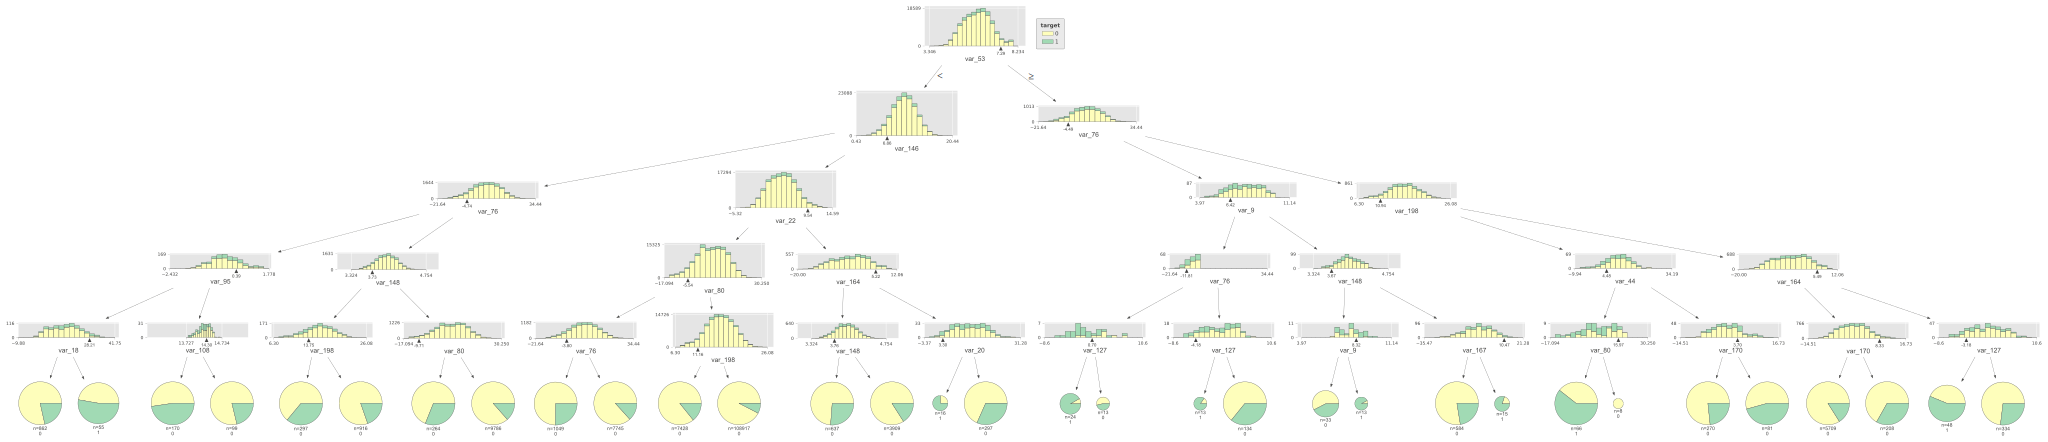

In [152]:
viz

From the plot above we can clearly visualize the process of how the decision tree algorithm work in the dark.

---
### Permutation Feature Importance

Permutation Feature importance is a model inspection technique that can be used for any fitted estimator when the data is rectangular. This is especially useful for non-linear or opaque estimators, since it's extremely difficult to predict whether or not a given feature is useful. 

Permutation Feature Importance is calculated after a model has been fitted. The question here is as follows:

> If I randomly shuffle a single column of the validation data, given all the otehr variables equal (including target variables and other dependent variables, how would this shuffle affect the accuracy of predictions? That is, how influencial this feature is for the entire dataset?

A feature with higher Permutation Feature Importance means that this feature is more powerful in affecting the result of the prediction. There are a handful of techniques that can visualize permutation feature importance, and the one we are going to use here is the renowned eli5 pacakge. Let's take a look at how to interpret the result!

In [153]:
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.ensemble import RandomForestClassifier

In [218]:
RFC = RandomForestClassifier(n_estimators=20,verbose=1).fit(X_train, y_train)
perm = PermutationImportance(RFC).fit(X_test, y_test)

In [155]:
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0003 ± 0.0002,var_53
0.0002 ± 0.0001,var_146
0.0002 ± 0.0002,var_0
0.0001 ± 0.0001,var_44
0.0001 ± 0.0001,var_42
0.0001 ± 0.0001,var_22
0.0001 ± 0.0002,var_69
0.0001 ± 0.0002,var_148
0.0001 ± 0.0002,var_95
0.0001 ± 0.0001,var_80


**How to interpret the results above?**

The values on the top are the most important features, and those at the bottom are the least important ones. Since there are randomness in the process as we shuffle the data randomly, the values one the left are the confidence interval for the actual importance for that variable. 

Sometimes you will see negative values for the permutation feature importance value, as we've seen for the variable. What does it mean by **negative importance**? In those cases, the predictions on the shuffled (or noisy) data happened to be more accurate than the real data. This happens when the feature didn't matter (should have had an importance close to 0), but random chance caused the predictions on shuffled data to be more accurate. This is more common with small datasets, like the one in this example, because there is more room for luck/chance.

In our example, the most important feature was **var_35**. Since the original feauture name is anonymized, we cannot tell whether it aligns with human intuition. However, it's the intuiton from the randm forest classifier.

---
### Partial Dependence Plot

Let's jump into another concept called **Partial Dependence Plot**. While permutation feature importance shows **what variables affect predictions the most**, partial dependence plots show **how a feature affects predictions**. That is, what will the change in values in that feature affect the result?

This is useful to answer questions like:

1. Others being equal, what impact do longitude and latitude have on home prices? To restate this, how would similarly sized houses be priced in different areas?

2. Are predicted health differences between two groups due to differences in their diets, or due to some other factor?

**Why Partial Dependence Plot is important?**

When using black box machine learning algorithms like random forest and boosting, it is hard to understand the relations between predictors and model outcome. For example, in terms of random forest, all we get is the feature importance. Although we can know which feature is significantly influencing the outcome based on the importance calculation, it really sucks that we don’t know in which direction it is influencing. And in most of the real cases, the effect is non-monotonic. We need some powerful tools to help understanding the complex relations between predictors and model prediction.

Here let's introduce a robust package for Partial Dependence Plot -- pdpbox. 

In [126]:
import matplotlib.pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

In [127]:
tree_model = DecisionTreeClassifier(random_state=0, max_depth=5, min_samples_split=5)
tree_model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [170]:
def draw_pdp_plot(mod, dataset, model_features, feature):
    plot = pdp.pdp_isolate(model=mod, dataset=dataset, model_features=model_features, feature=str(feature))
    pdp.pdp_plot(plot,str(feature))
    plt.show()

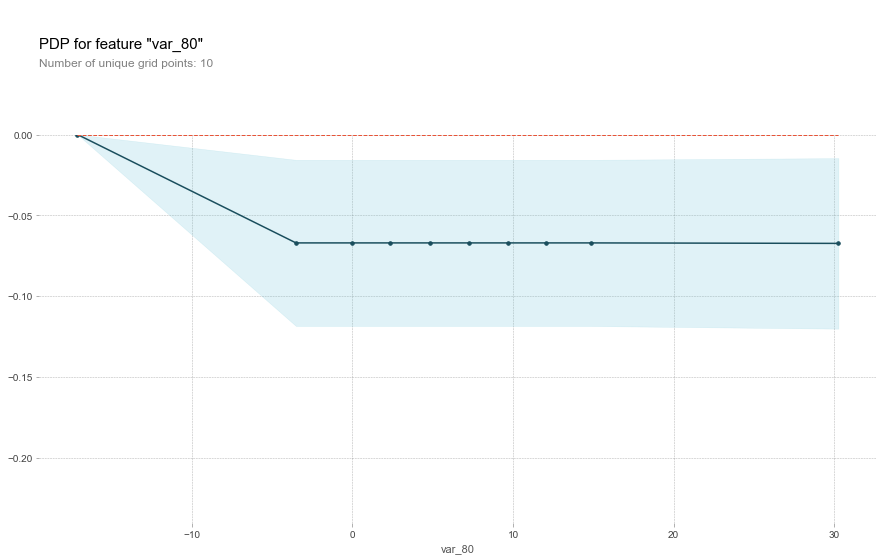

In [171]:
draw_pdp_plot(tree_model, X_train, features, 'var_80')

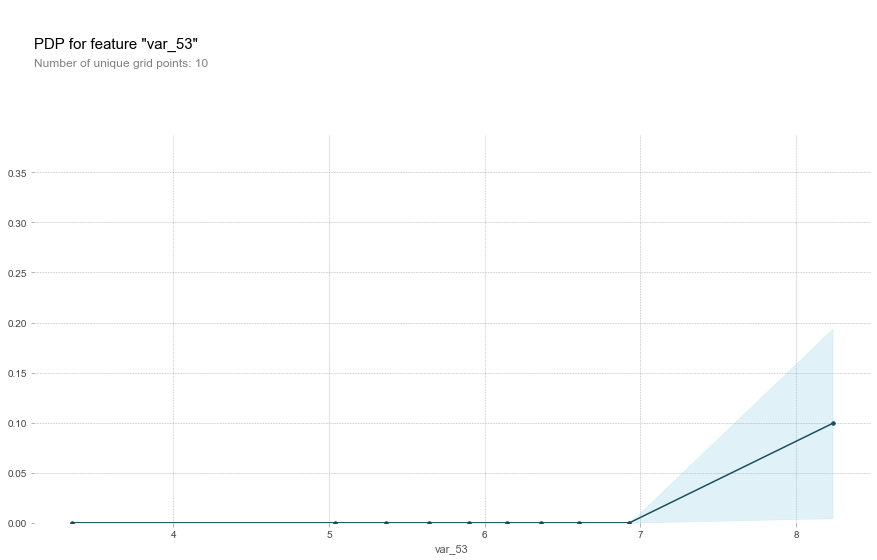

In [172]:
draw_pdp_plot(tree_model, X_train, features, 'var_53')

We can get some really interesting intuition from the plots above. For **var_80**, as the value increases from the mininum value, it's more likely to have the output toward 0 (negative effect of predicting 1). There's a plateau for positive values of feature var_80. That is, those positive values alike have similar effect for the output. For **var_53**, only vlaues over 7 have positive effects for output.

A few items are worth pointing out as you interpret this plot:

1. The y axis is interpreted as change in the prediction from what it would be predicted at the baseline or leftmost value.

2. A blue shaded area indicates level of confidence (confidence interval).


The graph is simple because of the nature of the model.
Let's try to build a randomforest to see if how does the plot looks like.

In [ ]:
# pdp.pdp_plot(pdp_var77, 'var_77', plot_lines=True)
# plt.show()

In [173]:
from sklearn.ensemble import RandomForestClassifier
rfc_model = RandomForestClassifier(random_state=0, max_depth=5, min_samples_split=5)
rfc_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

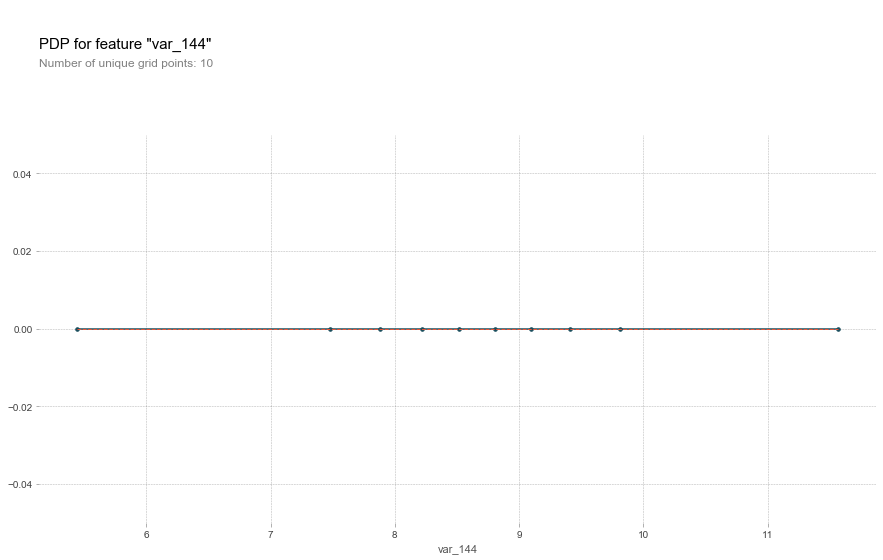

In [181]:
draw_pdp_plot(tree_model, X_test, features, 'var_144')

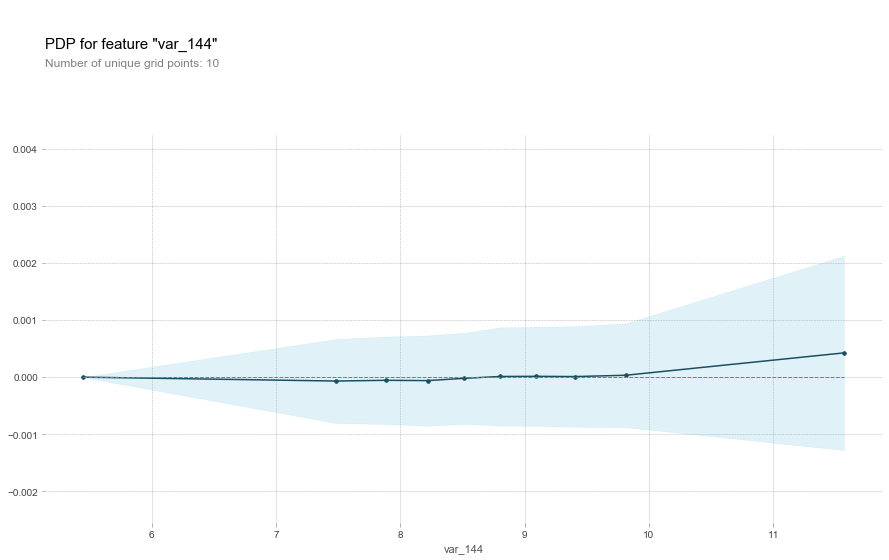

In [180]:
draw_pdp_plot(rfc_model, X_test, features, 'var_144')

Why there's a different partial dependence plot for the same variable **var_144**? We all know that RandomForest model is an ensemble method. Therefore, we can see zigzags in the plot compared to smoother lines in the DecisionTree model. The RandomForest partial dependence plot is more informative and worth taking care of compared to the DecisionTree one.

We've discussed how to analyze the effect of one feature to the ouptut. What if we want to compare two features at the same time? Here we can create a **2D Partial Dependence Plot**. Let's take a look at this method.

In [182]:
feature_set = ['var_80','var_82']

In [186]:
X_test.columns

Index(['var_20', 'var_130', 'var_82', 'var_32', 'var_76', 'var_96', 'var_126',
       'var_127', 'var_164', 'var_79', 'var_148', 'var_170', 'var_132',
       'var_198', 'var_47', 'var_30', 'var_108', 'var_7', 'var_134', 'var_88',
       'var_44', 'var_55', 'var_194', 'var_61', 'var_87', 'var_122', 'var_83',
       'var_0', 'var_159', 'var_18', 'var_104', 'var_59', 'var_39', 'var_161',
       'var_53', 'var_69', 'var_103', 'var_42', 'var_74', 'var_100', 'var_8',
       'var_23', 'var_146', 'var_95', 'var_185', 'var_167', 'var_144', 'var_9',
       'var_80', 'var_22'],
      dtype='object')

In [203]:
feature_set = ['var_18','var_76']

param = {
    'title_fontsize': 20,
    'subtitle_fontsize': 14,
    'cmap': 'plasma',
    'inter_fill_alpha': 0.6,
    'inter_fontsize': 12,
}
def draw_pdp_interaction_plot(mod, dataset, model_features, feature_set, param = param):
    plot = pdp.pdp_interact(model=mod, dataset=dataset, model_features=model_features, features=feature_set)
    pdp.pdp_interact_plot(pdp_interact_out=plot, feature_names=feature_set,plot_pdp=True,
                          plot_type='grid',x_quantile=True, plot_params = param)
    plt.show()

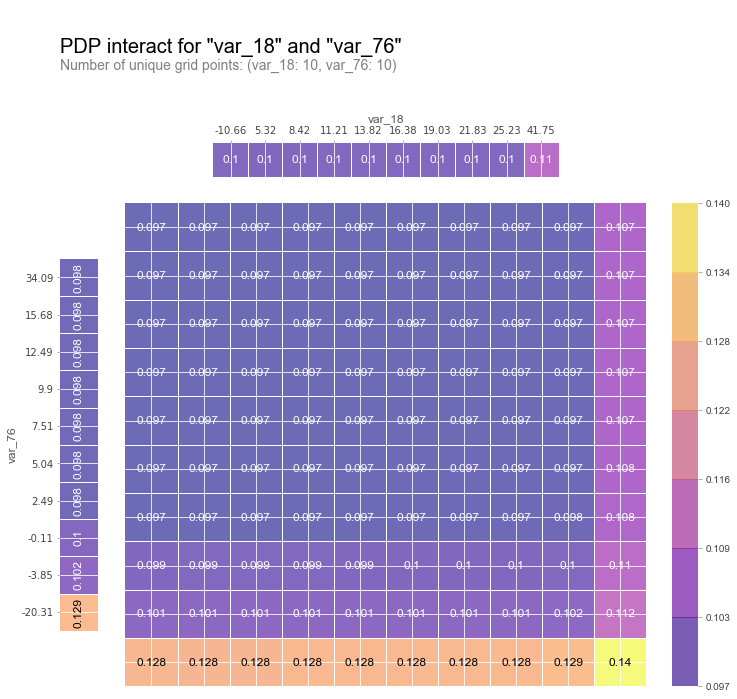

In [204]:
draw_pdp_interaction_plot(rfc_model, X_test, features, feature_set)

From the plot above, we can see the interaction effect between var_76 and var_18. The lower of the var_76 and the higher the var_18, the more likely that it will have positive effect on the output.

---
### Shap Values

The last technique we are going to discuss is SHAP Values. SHAP Values (an acronym from SHapley Additive exPlanations) break down a prediction to show the impact of each feature. SHAP values interpret the impact of having a certain value for a given feature in comparison to the prediction we'd make if that feature took some baseline value. 

Shap can answer to this qeustion : **how the model works for an individual prediction**?

In [214]:
import shap

row = 82
data_pred = X_test.iloc[row]
data_pred_array = data_pred.values.reshape(1,-1)
rfc_model.predict_proba(data_pred_array)

array([[0.8811, 0.1189]])

In [215]:
explainer = shap.TreeExplainer(rfc_model)
shap_values = explainer.shap_values(data_pred)

shap.initjs()
shap.force_plot(explainer.expected_value[1],shap_values[1],data_pred)

In [216]:
row = 1113
data_pred = X_test.iloc[row]
data_pred_array = data_pred.values.reshape(1,-1)
rfc_model.predict_proba(data_pred_array)

array([[0.8807, 0.1193]])

In [217]:
explainer = shap.TreeExplainer(rfc_model)
shap_values = explainer.shap_values(data_pred)

shap.initjs()
shap.force_plot(explainer.expected_value[1],shap_values[1],data_pred)

We can interpret the result as follows:

The baseline value is 0.12. For the observation of row 1113, the var_76 value *-15.86* has negative effect on the result, while the var_146 value *13.4* has positive effect on the result. Each observation will have different different shap plots since some features will not have much impacts to the output of that observation, given the interaction amomg lots of features.

---
### End Note

We have seen four different kinds of model explanation techniques -- tree visualization, permutation feature importance, partial dependence plot, and shap values. Each of these techniques are of different usage, and can all help interpret the machine learning black box algorithm to facilitate decision making process as well as business thinking.